In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms

In [3]:
!pip install galaxy-datasets[pytorch]

In [4]:
from galaxy_datasets import gz2

catalog, label_cols = gz2(
    root='/content/gz2',
    train=True,
    download=True
)

100%|██████████| 22392239/22392239 [00:00<00:00, 32020363.78it/s]


100%|██████████| 5852873/5852873 [00:00<00:00, 48728098.29it/s]


100%|██████████| 2671470353/2671470353 [01:10<00:00, 37733063.90it/s]


Extracting /content/gz2/images_gz2.tar.gz to /content/gz2


In [5]:
import pandas as pd

test_catalog_path = '/content/gz2/gz2_test_catalog.parquet'
test_catalog = pd.read_parquet(test_catalog_path)

print(test_catalog.head())

           ra        dec  smooth-or-featured-gz2_smooth  \
0  249.405838  44.450890                             34   
1  210.975311  14.511847                             40   
2  155.462067   4.318242                             29   
3  174.211868  22.719620                             45   
4  158.053574  21.829330                              1   

   smooth-or-featured-gz2_featured-or-disk  smooth-or-featured-gz2_artifact  \
0                                        1                                1   
1                                        2                                2   
2                                       11                                0   
3                                        3                                2   
4                                       37                                0   

   disk-edge-on-gz2_yes  disk-edge-on-gz2_no  bar-gz2_yes  bar-gz2_no  \
0                     0                    1            0           1   
1                     0 

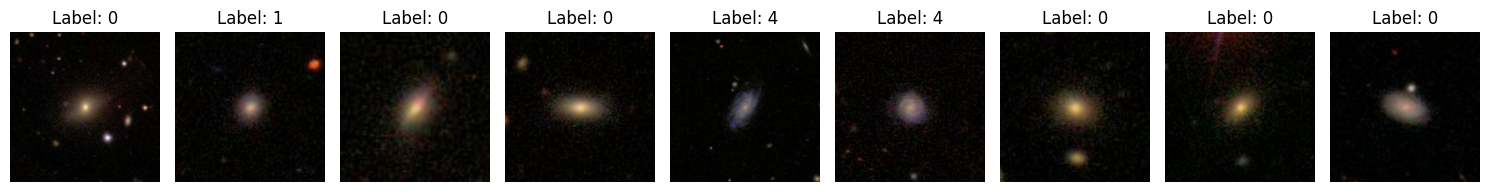

In [6]:

test_catalog_path = '/content/gz2/gz2_test_catalog.parquet'
test_catalog = pd.read_parquet(test_catalog_path)

image_ids = test_catalog['id_str'].tolist()
labels = test_catalog['label'].tolist()
subfolders = test_catalog['subfolder'].tolist()

image_paths = [os.path.join('/content/gz2/images/', subfolder, f"{image_id}.jpg") for subfolder, image_id in zip(subfolders, image_ids)]

num_images_to_display = 9
plt.figure(figsize=(15, 10))
for i in range(num_images_to_display):
    img_path = image_paths[i]
    label = labels[i]

    img = Image.open(img_path).convert('RGB')

    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class GalaxyZooTestDataset(Dataset):
    def __init__(self, test_catalog, transform=None):
        self.test_catalog = test_catalog
        self.transform = transform

    def __len__(self):
        return len(self.test_catalog)

    def __getitem__(self, idx):
        img_path = os.path.join('/content/gz2/images/',
                                self.test_catalog.iloc[idx]['subfolder'],
                                f"{self.test_catalog.iloc[idx]['id_str']}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.test_catalog.iloc[idx]['label']
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = GalaxyZooTestDataset(test_catalog, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:

model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 8)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from sklearn.metrics import accuracy_score


all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 31.11%


The accuracy is low as there is random initialization of weights and number of classes are also 8. And it is directly evaluated too.

In [7]:
class GalaxyZooDataset(Dataset):
    def __init__(self, catalog, root_dir, transform=None):
        self.catalog = catalog
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.catalog)

    def __getitem__(self, idx):
        row = self.catalog.iloc[idx]
        img_path = os.path.join(self.root_dir, "images", row['subfolder'], f"{row['id_str']}.jpg")
        image = Image.open(img_path).convert('RGB')
        label = row['label']

        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_catalog_path = '/content/gz2/gz2_train_catalog.parquet'
train_catalog = pd.read_parquet(train_catalog_path)
test_catalog_path = '/content/gz2/gz2_test_catalog.parquet'
test_catalog = pd.read_parquet(test_catalog_path)

# Replace -1 labels with 7
train_catalog['label'] = train_catalog['label'].replace(-1, 7)
test_catalog['label'] = test_catalog['label'].replace(-1, 7)


train_dataset = GalaxyZooDataset(train_catalog, root_dir='/content/gz2', transform=train_transform)
test_dataset = GalaxyZooDataset(test_catalog, root_dir='/content/gz2', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=4,pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:


num_classes = len(train_catalog['label'].unique())
model = models.resnet50(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 8)
model = model.to(device)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 3
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/3], Loss: 0.6226
Epoch [2/3], Loss: 0.5046
Epoch [3/3], Loss: 0.4578


In [ ]:
from sklearn.metrics import accuracy_score
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 82.55%


In [11]:
from torchvision.models import resnet50
from transformers import AutoModelForImageClassification
from peft import LoraConfig, get_peft_model

model = resnet50(pretrained=True)

lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=['fc'],
    lora_dropout=0.1,
    bias="none"
)

model = get_peft_model(model, lora_config).to('cuda')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
from torch.optim import Adam
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


  0%|          | 0/5233 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 5233/5233 [14:14<00:00,  6.13it/s]


Epoch 1, Loss: 1.8765126596598787


100%|██████████| 5233/5233 [13:59<00:00,  6.23it/s]


Epoch 2, Loss: 1.355317509336087


100%|██████████| 5233/5233 [13:21<00:00,  6.53it/s]

Epoch 3, Loss: 1.2924461658042405


In [13]:
def evaluate(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [14]:
# Evaluate on test_loader
test_accuracy = evaluate(model, test_loader)

Test Accuracy: 51.51%


The ccuracy will increase if number of epochs are also increased, i have a low end machine and no enough runtime on colab. So i have only taken 3 epochs